# SSDMobilenetv2 Implementation

MobileNet is a class of model that are called for applications in mobile and embedded level devices. Single Shot Detector or SSD is a technique based on a forward convolitional network that generates a collection of fixed size boxes and scores for presence of object class instances in that those boxes.

MobileNetSSD is an object detection model that where the SSD layer uses MobileNet as a backbone to achieve fast object detection on low power devices.

This notebook will show you how to use the MobileNetSSD model to detect objects in an image using OpenVINO™ toolkit.
Steps included here:

1. Downloading and loading the model
2. Observing results with original model
3. Converting model to IR format
4. Observing results with IR model


In [1]:
import tensorflow as tf 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import openvino.runtime as ov 
from pathlib import Path
from urllib.request import urlopen
import json

2023-03-18 17:00:04.583796: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-18 17:00:04.583902: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 1. Downloading and loading the model

We will be using tensorflow's get_file method to download the model. The model is documented at the [TensorFlowHub](https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1).
The specific model we will be using is the one that is trained on the COCO dataset. The model is trained to detect 90 classes of objects. The model is trained to detect objects in images of size 320x320 and also uses a feature pyramid network to detect objects at different scales.


In [2]:
# here we fetch the model and save it's directory in model_dir,tf.keras.utils.get_file() will download the model if it's not already downloaded and 
# Path() will convert the string to a path object
source = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
model_name = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
model_dir = Path(tf.keras.utils.get_file(model_name, source, untar=True))

Note : Since Tensorflow Object Detection API is not installed to keep in line with the requirement.txt, and the model is an Object Detection object, We will be using the serving_default signature to load the model and run inference on that with custom helper functions.


In [3]:
# here we load the model using tf.saved_model.load() and we get the signature of the model using model.signatures['serving_default']
model = tf.saved_model.load(model_dir / 'saved_model')
model = model.signatures['serving_default']

2023-03-18 17:00:11.356734: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/suhas/openvino_env/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-18 17:00:11.356805: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-18 17:00:11.356835: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Magnus): /proc/driver/nvidia/version does not exist
2023-03-18 17:00:11.357580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Observing results with original model

To keep notebook requirements minimum, we will be using the following helper functions to load the model and run inference on the model, this can also be done with TensorFlow's Object Detection API, but installing and getting that to work is beyond the scope of this notebook.


In [4]:
# to make it easier to work with the model we create a function that takes an image and preprocesses it for the model
def preprocess_image(image):
    """Preprocess an image for object detection by the ssd mobilenet model, images are scaled down to 320x320 and color channels are converted to RGB.
    Args: 
    image = path to image(string)"""
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert to RGB since model expects it that way
    image = cv2.resize(image, (320, 320))
    image = tf.convert_to_tensor(image, dtype=tf.uint8)
    image = tf.expand_dims(image, axis=0)
    return image

In [5]:
# to visualize the output of the model we create a function that takes 
# the output of the model and the image and displays the image with 
# bounding boxes of objects detected with a certain confidence threshold
def inference_engine(image,output,id_to_display_name,confidence_threshold=0.6):
    """Visualizes the output of the model. 
    Arguments:
        image = path to image(string)
        output = output of the model(dictionary)
        id_to_display_name = dictionary mapping class id to class name
        confidence_threshold = threshold for displaying bounding boxes(float)"""
    # reading the image and making a copy of it
    image = cv2.imread(image)
    image_stock = image.copy()
    image_stock = cv2.cvtColor(image_stock, cv2.COLOR_BGR2RGB)
    # taking relevant outputs from the model
    boxes = output['detection_boxes']
    classes = output['detection_classes']
    scores = output['detection_scores']
    num_detections = output['num_detections']
    for i in range(int(num_detections[0])):
        # if the confidence score is greater than the threshold we draw a bounding box around the object
        if scores[0][i] > confidence_threshold:
            box = boxes[0][i]
            ymin = int(box[0] * image.shape[0])
            xmin = int(box[1] * image.shape[1])
            ymax = int(box[2] * image.shape[0])
            xmax = int(box[3] * image.shape[1])
            class_id = int(classes[0][i])
            # get the name of the class from the dictionary, replace with 'Label unknown' if not found
            display_name = id_to_display_name.get(class_id,f'Label unknown {class_id}')
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2) #drawing rectangle
            text = f"{display_name} {scores[0][i]:.2f}" #text to be displayed along with confidence score
            cv2.putText(image, text, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    # plotting the image
    fig, axs = plt.subplots(1, 2,figsize=(20, 20))
    # ax[0] shows the output of the model and ax[1] shows the original image
    # for ax[0] we convert the image from BGR to RGB since cv2 reads images in BGR format
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[1].imshow(image_stock)
    axs[0].set_title('Inference Engine Output')
    axs[1].axis('off')
    axs[1].set_title('Original Image')
    axs[0].axis('off')
    plt.show()

To construct the label map, we will use urlopen method from [urllib.response](https://docs.python.org/3/library/urllib.request.html) library to work with [classes.json](https://raw.githubusercontent.com/RuneSkovrupHansen/openvino-examples/bb945203b32647dd37e0eff9a07564c33fe7b7b7/models/ssd_mobilenet_v2_coco/classes.json).An added advantage here is that we won't have to download and save the file itself.


In [6]:
file_source = 'https://raw.githubusercontent.com/RuneSkovrupHansen/openvino-examples/bb945203b32647dd37e0eff9a07564c33fe7b7b7/models/ssd_mobilenet_v2_coco/classes.json'
url_response = urlopen(file_source)  # open the url and record the response
json_object = json.loads(url_response.read())  # read the response and convert it to a json object
id_to_display_name = {int(k):v for k,v in json_object.items()}  # map json object to a dictionary

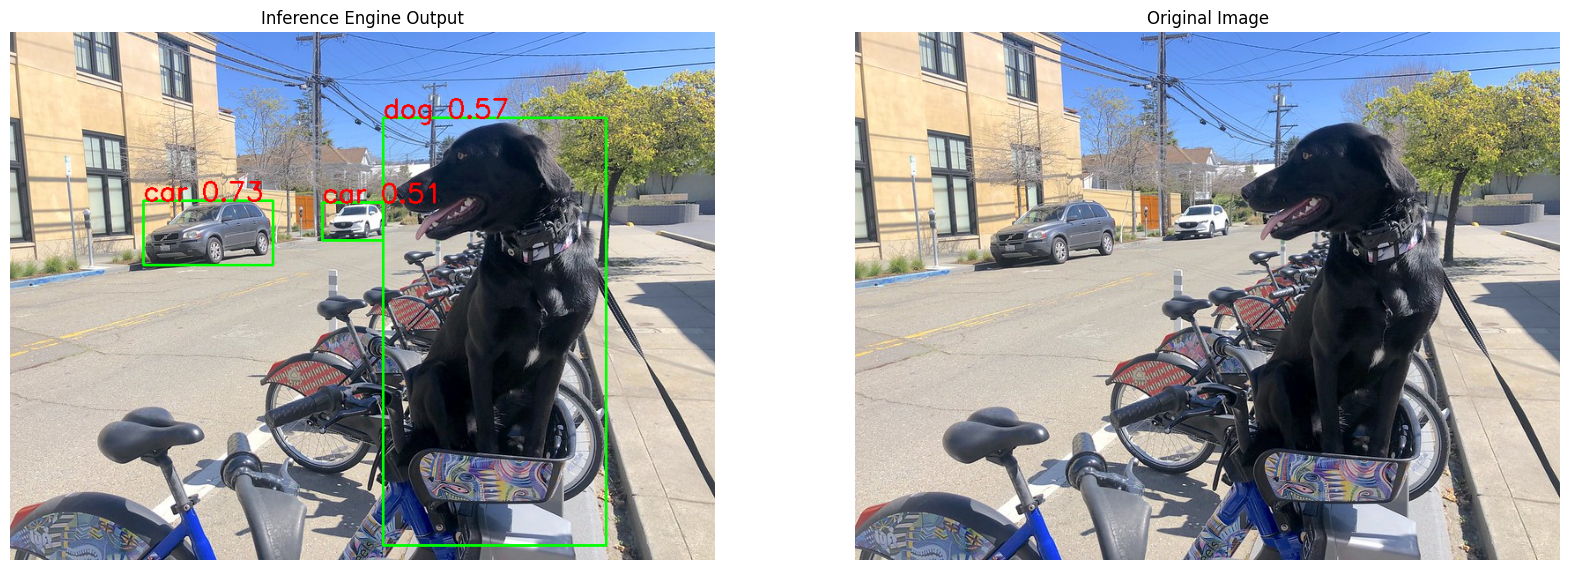

In [7]:
image_path = Path('../data/image/coco_bike.jpg')  # set image path
processed_image = preprocess_image(str(image_path))  # preprocess the image
output_original = model(processed_image)  # run the model on the image
inference_engine(str(image_path),output_original,id_to_display_name,confidence_threshold=0.5)

## 3. Converting model to IR format


In [8]:
output_dir = Path('model')
mo_command = f"""mo
                 --saved_model_dir "{model_dir/'saved_model'}"
                 --input_shape "[1,320,320,3]"
                 --model_name "{model_name}"
                 --tensorflow_object_detection_api_pipeline_config "{model_dir/'pipeline.config'}"
                 --output_dir "{output_dir/model_name}"
                 """
mo_command = " ".join(mo_command.split())

In [ ]:
if not output_dir.exists():
    print("Exporting TensorFlow model, please wait patiently!")
    ! $mo_command
else:
    print(f"IR model {output_dir} already exists!")

Exporting TensorFlow model, please wait patiently!
/home/suhas/openvino_env/lib/python3.10/site-packages/keras/layers/core/lambda_layer.py:303: UserWarning: google3.third_party.tensorflow.python.ops.nn_ops is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,
/home/suhas/openvino_env/lib/python3.10/site-packages/keras/layers/core/lambda_layer.py:303: UserWarning: google3.third_party.tensorflow_models.object_detection.models.feature_map_generators is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,
[ WARNING ]  Changing Const node 'StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/PadOrClipBoxList/Slice_3/where_max_ends_is_needed_input_port_0/value' data type from int64 to int32 for Equal operation
[ WARNING ]  Changing Const node 'StatefulPartitionedCall/Postprocessor/BatchMultiClassNonMaxSuppression/PadOrCl

## 4. Observing results with IR model


In [ ]:
# here we load the model into the OpenVINO runtime, read the model and compile it for the CPU
core = ov.Core()  # starting the OpenVINO runtime
model_ov = core.read_model(f'{str(output_dir/model_name/model_name)}.xml',f'{str(output_dir/model_name/model_name)}.bin')  # reading the model
model_ov = core.compile_model(model_ov,"CPU")  # compiling on CPU

In [ ]:
# here we preprocess the image and convert it to an OpenVINO tensor
image_preprocessed_ov = np.array(preprocess_image(str(image_path)))  # preprocessing the image, 
                                                                     #converting to numpy array as OpenVINO expects it that way
input_tensor = ov.Tensor(array = image_preprocessed_ov) # setting the image as the input tensor

In [ ]:
# here we create an inference request and set the input tensor
infer_request = model_ov.create_infer_request()  # creating an inference request
infer_request.set_input_tensor(input_tensor)  # setting the input tensor to the inference request

In [ ]:
# here we start the inference and wait for it to finish
infer_request.start_async()
infer_request.wait()

In [ ]:
# here we create an empty dictionary and assign the output tensors to it, we can then use the dictionary to visualize the output
output_ov ={}
output_ov['num_detections'] = infer_request.get_output_tensor(7).data
output_ov['detection_scores'] = infer_request.get_output_tensor(6).data
output_ov['detection_boxes'] = infer_request.get_output_tensor(3).data
output_ov['detection_classes']  = infer_request.get_output_tensor(4).data

In [ ]:
inference_engine(str(image_path),output_ov,id_to_display_name,confidence_threshold=0.5)